<a href="https://colab.research.google.com/github/KateT840/Lab_moderna_con_Emma/blob/main/Ondas/Lab_ondas4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Suba.csv to Suba.csv


In [ ]:
import pandas as pd

# Leer el archivo indicando otra codificación
df = pd.read_csv('Suba.csv', header=None, encoding='latin1')  # latin1 es ISO-8859-1

# Mostrar las primeras filas para inspeccionar
print(df.head(20))


                   0                                           1        2  \
0      Record Length                                        2500   Points   
1    Sample Interval                             400.00000467E-9        s   
2      Trigger Point                                 1.1500000E3  Samples   
3                NaN                                         NaN      NaN   
4                NaN                                         NaN      NaN   
5                NaN                                         NaN      NaN   
6             Source                                         CH1      NaN   
7     Vertical Units                                       Volts      NaN   
8     Vertical Scale                                   2.0000000      NaN   
9    Vertical Offset                                           0      NaN   
10  Horizontal Units                                           s      NaN   
11  Horizontal Scale                              100.0000012E-6      NaN   

In [ ]:
# Suponiendo que las columnas de tiempo y voltaje son la 4 y 5
time = df.iloc[11:, 3].astype(float)
voltage = df.iloc[11:, 4].astype(float)

# Convertir a un DataFrame limpio
data = pd.DataFrame({'Time': time, 'Voltage': voltage})
print(data.head())


        Time  Voltage
11 -0.000456    -4.88
12 -0.000455    -4.88
13 -0.000455    -4.88
14 -0.000454    -4.88
15 -0.000454    -4.96


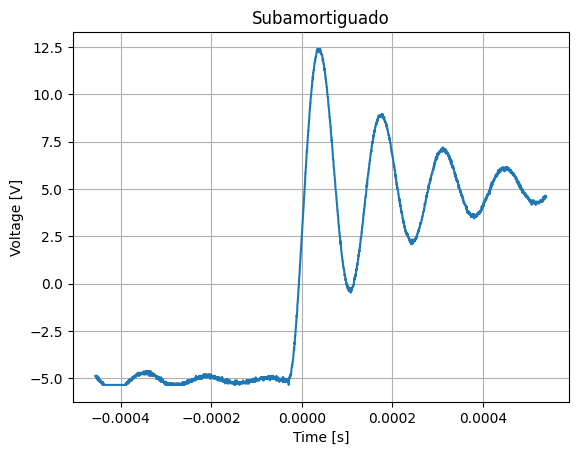

In [ ]:
import matplotlib.pyplot as plt

plt.plot(data['Time'], data['Voltage'])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.title('Subamortiguado')
plt.grid(True)
plt.savefig('subamortiguado.png', dpi=300)
plt.show()


In [ ]:
from google.colab import files

# Descargar la imagen guardada
files.download('subamortiguado.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V0 = -44.141 V
gamma = 2960.915 rad/s
omega = 5647.178 rad/s
Voff = 2.238 V


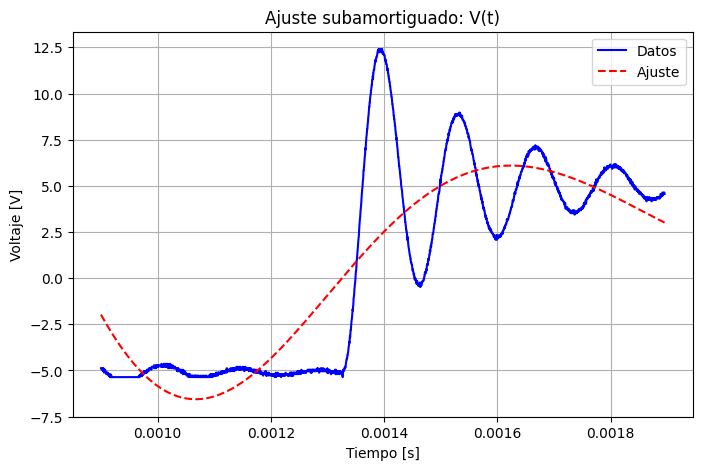

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -----------------------------
# Datos (asegúrate de tener data['Time'] y data['Voltage'])
# -----------------------------


time = data['Time'].values
time = time - time[0] + 0.0009  # ahora el primer punto es 0.00005 s
voltage = data['Voltage'].values


# -----------------------------
# Función de ajuste subamortiguado
# -----------------------------
def V_sub(t, V0, gamma, omega, Voff):
    return V0 * np.exp(-gamma/2 * t) * np.cos(omega * t) + Voff

# -----------------------------
# Estimaciones iniciales de parámetros
# -----------------------------
V0_guess = voltage.max() - voltage.min()
gamma_guess = 1000            # ajustar según la escala de tiempo de tu señal
omega_guess = 2 * np.pi * 1000  # frecuencia inicial aproximada en rad/s
Voff_guess = np.mean(voltage)   # promedio de la señal

# -----------------------------
# Ajuste no lineal
# -----------------------------
popt, pcov = curve_fit(V_sub, time, voltage, p0=[V0_guess, gamma_guess, omega_guess, Voff_guess])

V0_fit, gamma_fit, omega_fit, Voff_fit = popt
print(f"V0 = {V0_fit:.3f} V")
print(f"gamma = {gamma_fit:.3f} rad/s")
print(f"omega = {omega_fit:.3f} rad/s")
print(f"Voff = {Voff_fit:.3f} V")

# -----------------------------
# Graficar datos y ajuste
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(time, voltage, label='Datos', color='blue')
plt.plot(time, V_sub(time, *popt), label='Ajuste', linestyle='--', color='red')
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [V]')
plt.title('Ajuste subamortiguado: V(t)')
plt.legend()
plt.grid(True)

# Guardar imagen
plt.savefig('subamortiguado_ajuste.png', dpi=300)
plt.show()



Parámetros ajustados:
V0 = 4.944 V
gamma = 14074.293 rad/s
omega = 29720.746 rad/s
Voff = 5.264 V


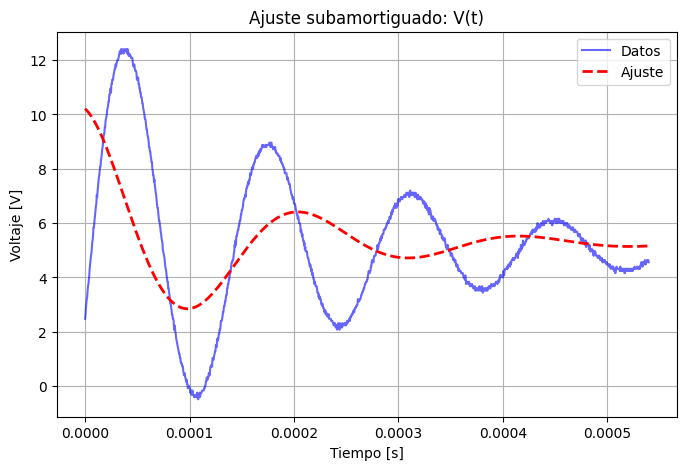

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# -----------------------------
# Datos
# -----------------------------
time = data['Time'].values
voltage = data['Voltage'].values

# -----------------------------
# Recortar datos desde el primer tiempo >= 0
# -----------------------------
mask = time >= 0
time = time[mask]
voltage = voltage[mask]

# -----------------------------
# Función de ajuste subamortiguado
# -----------------------------
def V_sub(t, V0, gamma, omega, Voff):
    return V0 * np.exp(-gamma/2 * t) * np.cos(omega * t) + Voff

# -----------------------------
# Estimaciones iniciales usando picos
# -----------------------------
peaks, _ = find_peaks(voltage, prominence=0.01, distance=5)

if len(peaks) >= 2:
    V_peaks = voltage[peaks]
    V_peaks = V_peaks[V_peaks > 0]  # evitar log de negativos
    if len(V_peaks) >= 2:
        periods = np.diff(time[peaks][:len(V_peaks)])
        T_avg = np.mean(periods)
        omega_guess = max(2 * np.pi / T_avg, 1e-6)  # evitar cero
        gamma_guess = -2 * np.mean(np.log(V_peaks[1:] / V_peaks[:-1]) / periods)
        gamma_guess = max(gamma_guess, 1e-6)        # evitar negativo o cero
    else:
        omega_guess = 2 * np.pi * 1000
        gamma_guess = 1e-6
else:
    omega_guess = 2 * np.pi * 1000
    gamma_guess = 1e-6

V0_guess = max(voltage.max() - voltage.min(), 1e-6)
Voff_guess = np.mean(voltage)

# -----------------------------
# Ajuste no lineal con límites
# -----------------------------
# V0 >=0, gamma >=0, omega >=0, Voff sin límite
bounds = ([0, 0, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf])
popt, pcov = curve_fit(V_sub, time, voltage,
                       p0=[V0_guess, gamma_guess, omega_guess, Voff_guess],
                       bounds=bounds)

V0_fit, gamma_fit, omega_fit, Voff_fit = popt

print("\nParámetros ajustados:")
print(f"V0 = {V0_fit:.3f} V")
print(f"gamma = {gamma_fit:.3f} rad/s")
print(f"omega = {omega_fit:.3f} rad/s")
print(f"Voff = {Voff_fit:.3f} V")

# -----------------------------
# Graficar señal y ajuste
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(time, voltage, label='Datos', color='blue', alpha=0.6)
plt.plot(time, V_sub(time, *popt), label='Ajuste', linestyle='--', color='red', linewidth=2)

plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [V]')
plt.title('Ajuste subamortiguado: V(t)')
plt.legend()
plt.grid(True)
#plt.savefig('subamortiguado_ajuste.png', dpi=300)
plt.show()


Primer pico >12 V en t = 0.000033 s, V = 12.320 V


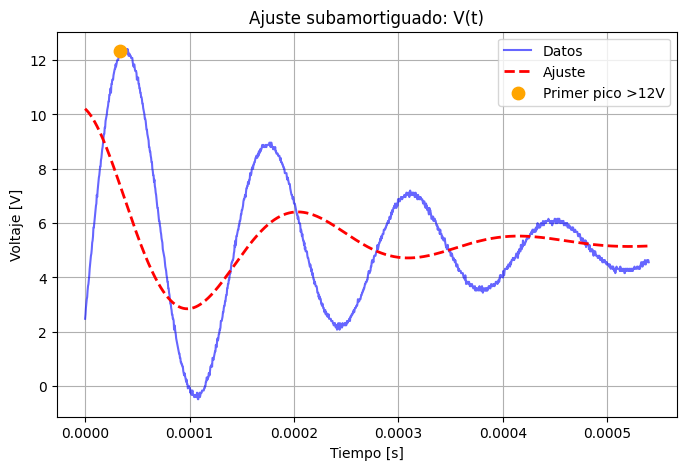

In [ ]:
# Encontrar todos los picos
peaks, _ = find_peaks(voltage, prominence=0.01, distance=5)

# Filtrar solo los picos mayores a 12 V
big_peaks = [i for i in peaks if voltage[i] > 12]

if len(big_peaks) > 0:
    first_peak_index = big_peaks[0]
    first_peak_time = time[first_peak_index]
    first_peak_voltage = voltage[first_peak_index]
    print(f"Primer pico >12 V en t = {first_peak_time:.6f} s, V = {first_peak_voltage:.3f} V")
else:
    print("No hay picos mayores a 12 V.")

# Graficar señal, ajuste y primer pico grande
plt.figure(figsize=(8,5))
plt.plot(time, voltage, label='Datos', color='blue', alpha=0.6)
plt.plot(time, V_sub(time, *popt), label='Ajuste', linestyle='--', color='red', linewidth=2)

# Marcar primer pico grande
if len(big_peaks) > 0:
    plt.scatter(first_peak_time, first_peak_voltage, color='orange', s=80, label='Primer pico >12V', zorder=5)

plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [V]')
plt.title('Ajuste subamortiguado: V(t)')
plt.legend()
plt.grid(True)
#plt.savefig('subamortiguado_ajuste.png', dpi=300)
plt.show()


Nuevo inicio: t[0] = 0.00000000 s, V[0] = 12.240 V

Parámetros ajustados:
V0 = 7.860 V
gamma = 9919.893 rad/s
omega = 44063.057 rad/s
Voff = 5.114 V
Primer pico >12 V en t = 0.000002 s, V = 12.400 V
Coeficiente de correlación entre datos y ajuste: r = 0.9770


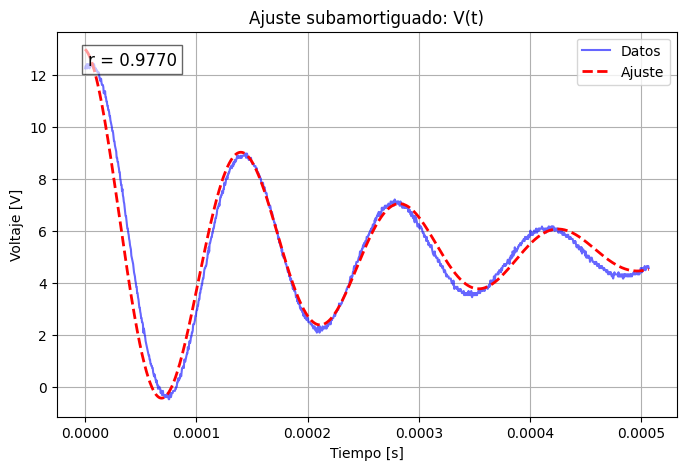

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# -----------------------------
# Datos
# -----------------------------
time = data['Time'].values
voltage = data['Voltage'].values

# -----------------------------
# Recortar datos desde el punto deseado
# -----------------------------
t_start = 0.000033   # s
V_start = 12.320     # V

# Índice más cercano a t_start
idx_start = np.argmin(np.abs(time - t_start))

time = time[idx_start:] - time[idx_start]   # ahora el primer tiempo es t=0
voltage = voltage[idx_start:]              # V ≈ 12.320 V

print(f"Nuevo inicio: t[0] = {time[0]:.8f} s, V[0] = {voltage[0]:.3f} V")

# -----------------------------
# Función de ajuste subamortiguado
# -----------------------------
def V_sub(t, V0, gamma, omega, Voff):
    return V0 * np.exp(-gamma/2 * t) * np.cos(omega * t) + Voff

# -----------------------------
# Estimaciones iniciales usando picos
# -----------------------------
peaks, _ = find_peaks(voltage, prominence=0.01, distance=5)

if len(peaks) >= 2:
    V_peaks = voltage[peaks]
    V_peaks = V_peaks[V_peaks > 0]  # evitar log de negativos
    if len(V_peaks) >= 2:
        periods = np.diff(time[peaks][:len(V_peaks)])
        T_avg = np.mean(periods)
        omega_guess = max(2 * np.pi / T_avg, 1e-6)  # evitar cero
        gamma_guess = -2 * np.mean(np.log(V_peaks[1:] / V_peaks[:-1]) / periods)
        gamma_guess = max(gamma_guess, 1e-6)        # evitar negativo o cero
    else:
        omega_guess = 2 * np.pi * 1000
        gamma_guess = 1e-6
else:
    omega_guess = 2 * np.pi * 1000
    gamma_guess = 1e-6

V0_guess = max(voltage.max() - voltage.min(), 1e-6)
Voff_guess = np.mean(voltage)

# -----------------------------
# Ajuste no lineal con límites
# -----------------------------
bounds = ([0, 0, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf])
popt, pcov = curve_fit(V_sub, time, voltage,
                       p0=[V0_guess, gamma_guess, omega_guess, Voff_guess],
                       bounds=bounds)

V0_fit, gamma_fit, omega_fit, Voff_fit = popt

print("\nParámetros ajustados:")
print(f"V0 = {V0_fit:.3f} V")
print(f"gamma = {gamma_fit:.3f} rad/s")
print(f"omega = {omega_fit:.3f} rad/s")
print(f"Voff = {Voff_fit:.3f} V")

# -----------------------------
# Primer pico > 12 V
# -----------------------------
big_peaks = [i for i in peaks if voltage[i] > 12]

if len(big_peaks) > 0:
    first_peak_index = big_peaks[0]
    first_peak_time = time[first_peak_index]
    first_peak_voltage = voltage[first_peak_index]
    print(f"Primer pico >12 V en t = {first_peak_time:.6f} s, V = {first_peak_voltage:.3f} V")
else:
    first_peak_time = None
    first_peak_voltage = None
    print("No hay picos mayores a 12 V.")

y = voltage
f = V_sub(time, *popt)
r = np.corrcoef(y, f)[0, 1]
print(f"Coeficiente de correlación entre datos y ajuste: r = {r:.4f}")
# -----------------------------
# Graficar señal y ajuste con correlación
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(time, voltage, label='Datos', color='blue', alpha=0.6)
plt.plot(time, f, label='Ajuste', linestyle='--', color='red', linewidth=2)

# Agregar texto de correlación en la gráfica
plt.text(0.05, 0.95, f"r = {r:.4f}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [V]')
plt.title('Ajuste subamortiguado: V(t)')
plt.legend()
plt.grid(True)
#plt.savefig('subamortiguado_ajuste.png', dpi=300)
plt.show()


In [ ]:
#from google.colab import files

# Descargar la imagen guardada
#files.download('subamortiguado_ajuste.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# -----------------------------
# Correlación entre datos y ajuste
# -----------------------------
y = voltage
f = V_sub(time, *popt)

r = np.corrcoef(y, f)[0, 1]
print(f"Coeficiente de correlación entre datos y ajuste: r = {r:.4f}")


Coeficiente de correlación entre datos y ajuste: r = 0.9770



Parámetros ajustados con incertidumbre:
A = V0 = $(7.860 \pm 6.9)\,V$
γ = $(9.920 \pm 1.3) \times 10^{3}\,1/s$
ω = $(4.406 \pm 4.6) \times 10^{4}\,rad/s$


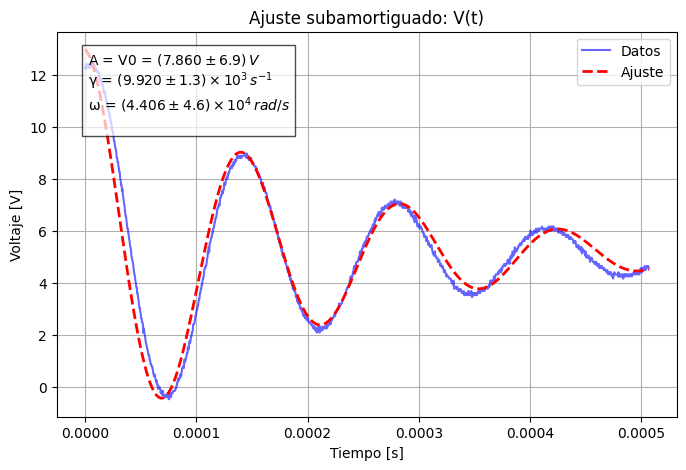

In [ ]:
def sci_notation(val, err, unit=""):
    """
    Devuelve string en notación científica estilo LaTeX:
    (a.bc ± d.de) × 10^{n}, pero si n=0 se omite.
    """
    s_val = f"{val:.3e}"
    s_err = f"{err:.1e}"

    base_val, exp_val = s_val.split("e")
    base_err, exp_err = s_err.split("e")
    exp = int(exp_val)

    if exp == 0:
        return fr"$({float(base_val):.3f} \pm {float(base_err):.1f})\,{unit}$"
    else:
        return fr"$({float(base_val):.3f} \pm {float(base_err):.1f}) \times 10^{{{exp}}}\,{unit}$"
# Ajuste no lineal con límites
# -----------------------------
bounds = ([0, 0, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf])
popt, pcov = curve_fit(V_sub, time, voltage,
                       p0=[V0_guess, gamma_guess, omega_guess, Voff_guess],
                       bounds=bounds)

V0_fit, gamma_fit, omega_fit, Voff_fit = popt

# Incertidumbres
perr = np.sqrt(np.diag(pcov))
V0_err, gamma_err, omega_err, Voff_err = perr

# Después del ajuste
# -----------------------------
print("\nParámetros ajustados con incertidumbre:")
print("A = V0 =", sci_notation(V0_fit, V0_err, "V"))
print("γ =", sci_notation(gamma_fit, gamma_err, "1/s"))
print("ω =", sci_notation(omega_fit, omega_err, "rad/s"))

# -----------------------------
# Graficar señal y ajuste con parámetros en la leyenda
# -----------------------------
y = voltage
f = V_sub(time, *popt)
r = np.corrcoef(y, f)[0, 1]

plt.figure(figsize=(8,5))
plt.plot(time, voltage, label='Datos', color='blue', alpha=0.6)
plt.plot(time, f, label='Ajuste', linestyle='--', color='red', linewidth=2)

# Texto para la gráfica
# -----------------------------
param_text = (
    f"A = V0 = {sci_notation(V0_fit, V0_err, 'V')}\n"
    f"γ = {sci_notation(gamma_fit, gamma_err, 's^{{-1}}')}\n"
    f"ω = {sci_notation(omega_fit, omega_err, 'rad/s')}\n"
)

plt.text(0.05, 0.95, param_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7))
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [V]')
plt.title('Ajuste subamortiguado: V(t)')
plt.legend()
plt.grid(True)
#plt.savefig('valores.png', dpi=300)
plt.show()


In [ ]:
#from google.colab import files

#Descargar la imagen guardada
#files.download('valores.png')